In [1]:
%pylab inline
import os
import haloSim
import ipyvolume as ipv
import ipyvolume.pylab as pvlt
import astropy.io.fits as pyfits
from configparser import ConfigParser
from pixel3D import cartesianGrid3D
from sparseBase import massmapSparsityTask
#important constant
C_LIGHT=2.99792458e8        # m/s
GNEWTON=6.67428e-11         # m^3/kg/s^2
KG_PER_SUN=1.98892e30       # kg/M_solar
M_PER_PARSEC=3.08568025e16  # m/pc

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/stampSim/HSC-like

/lustre2/work/xiangchong.li/massMapSim/stampSim/HSC-like


# Simulation

In [36]:
iz  =   3
im  =   5

log_m_array=np.linspace(13.5,15.5,9)
z_array=np.linspace(0.01,1.01,9)
names=('iz','im','zh','log10_M200','conc','rs_arcmin')
data=[]
z_h=z_array[iz]
log_m=log_m_array[im]
M_200=   10.**(log_m)
conc =   6.02*(M_200/1.E13)**(-0.12)*(1.47/(1.+z_h))**(0.16)
halo =   haloSim.nfw_lensTJ03(mass=M_200,conc=conc,redshift=z_h,ra=0.,dec=0.)
print('redshift is %.2f' %z_h)
print('logM is %.2f' %log_m)

redshift is 0.39
logM is 14.75


# pixelation

In [37]:
hdir='process-equalNum-test2'
configName  =   os.path.join(hdir,'config.ini')
parser      =   ConfigParser()
parser.read(configName)

outfname1   =  os.path.join(hdir,'pixShearR-g1-%d-%d-zt.fits' %(iz,im))
outfname2   =  os.path.join(hdir,'pixShearR-g2-%d-%d-zt.fits' %(iz,im))
parser.set('prepare','g1fname',outfname1)
parser.set('prepare','g2fname',outfname2)

parser.set('transPlane','smooth_scale','1.5')
print(parser.get('transPlane','smooth_scale'))
print(parser.get('prepare','g2fname'))

gridInfo    =   cartesianGrid3D(parser)

if not os.path.isfile(outfname1):
    ngroup  =   100
    raname  =   'raR'
    decname =   'decR'
    if False:
        zname   =   'zbest'
    else:
        zname   =   'ztrue'
    g1name  =   'g1R'
    g2name  =   'g2R'

    infname =   'sims/stampSim-HSC_like-TJ03-%d,%d-202004021856.fits' %(iz,im)
    datTab  =   pyfits.getdata(infname)
    ng=len(datTab)//ngroup
    ig=0
    datU=datTab[ig*ng:(ig+1)*ng]
    
    val=(datU[g1name]+datU['g1n'])+(datU[g2name]+datU['g2n'])*1j
    #val=(datU[g1name])+(datU[g2name])*1j
    outcome=gridInfo.pixelize_data(datU[raname],datU[decname],datU[zname],val)
    pyfits.writeto(outfname1,outcome.real,overwrite=True)
    pyfits.writeto(outfname2,outcome.imag,overwrite=True)
    
dtheta=parser.getfloat('transPlane','scale')*60. #arcsec
print('rs of the input halo is %.3f pixels.' %(halo.rs_arcsec/dtheta))
print('r truncate of the input halo is %.3f pixels.' %(halo.rs_arcsec/dtheta*halo.c))
print('the average density contrast should be %.3f.' %(halo.M/(halo.rs/halo.c)**2./np.pi/halo.Sigma_M_bin(0.51,0.56)))
print(halo.M)

1.5
process-equalNum-test2/pixShearR-g2-3-5-zt.fits
rs of the input halo is 1.424 pixels.
r truncate of the input halo is 5.336 pixels.
the average density contrast should be 4.879.
562341325190349.06


In [38]:
print(log_m_array)
print(z_array)

[13.5  13.75 14.   14.25 14.5  14.75 15.   15.25 15.5 ]
[0.01  0.135 0.26  0.385 0.51  0.635 0.76  0.885 1.01 ]


In [39]:
tau=3.9012834053533106e-05*20.
parser.set('sparse','lbd','4.' )
parser.set('sparse','nframe','4' )
parser.set('sparse','tau','%s' %tau)
parser.set('sparse','debugList','[]')
sparse3D    =   massmapSparsityTask(parser)

1.948911519268917e-05
3.90128340535331e-05


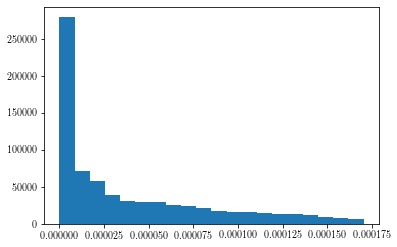

In [40]:
#Spectrum
hist=plt.hist(1./sparse3D.mu0.flatten(),bins=20)
print(np.median(1./sparse3D.mu0.flatten()))
print(np.average(1./sparse3D.mu0.flatten()))

shape of lensing kernel:  (10, 20)
0.0022940221689978935 0.0023494941050501024 0.97638983816432
0.005103261665544123 0.0052209483992906505 0.9774587441311396
0.007387899059891602 0.007550722166610481 0.9784360882143317
0.00921216672508998 0.00940657152851238 0.9793330861480044
0.010655136284139433 0.01087082238476006 0.9801591735209473
0.011702945886269715 0.01193055278261125 0.980922351169405
0.012393430767870419 0.012625365640400501 0.9816294530284412
0.012789310450761971 0.013019941055797122 0.982286355671905
0.012964444903547935 0.013190018709063112 0.9828981436273339
0.012940420446276983 0.013157931034524123 0.9834692408953635


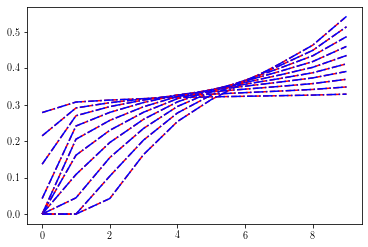

In [41]:
lk1=gridInfo.lensing_kernel()
lk2=sparse3D.lensKernel
print('shape of lensing kernel: ',lk1.shape)
for izl in range(0,10):
    norm1=np.sqrt(np.sum(lk1[:,izl]**2.))
    norm2=np.sqrt(np.sum(lk2[:,izl]**2.))
    print(norm1,norm2,norm1/norm2)
    plt.plot(lk1[:,izl]/norm1,'--',c='red')
    plt.plot(lk2[:,izl]/norm2,'-.',c='blue')

# sparse analysis

In [44]:
sparse3D.process(1500)

1 10.334267588496242 (9, 0, 48, 49) 10.334267588496242 4.04
6 12.794257917747569 (9, 0, 49, 50) 12.794257917747569 4.04
11 18.85104240623571 (9, 0, 46, 49) 18.85104240623571 4.04
16 17.540392636906475 (9, 0, 49, 47) 17.540392636906475 4.04
21 17.516363975403937 (9, 0, 47, 46) 17.516363975403937 4.04
26 19.099593699904638 (9, 0, 45, 49) 19.099593699904638 4.04
31 16.908032315633847 (9, 0, 47, 45) 16.908032315633847 4.04
36 15.002471531309727 (9, 0, 50, 45) 15.002471531309727 4.04
41 15.921739334286212 (9, 0, 45, 45) 15.921739334286212 4.04
46 13.456949014314436 (9, 0, 48, 44) 13.456949014314436 4.04
51 14.671176625806565 (9, 0, 47, 51) 14.671176625806565 4.04
56 12.110652640951656 (9, 0, 43, 47) 12.110652640951656 4.04
61 12.482929283805959 (9, 0, 43, 46) 12.482929283805959 4.04
66 10.821905835893663 (9, 0, 51, 45) 10.821905835893663 4.04
71 10.348221283497882 (9, 0, 42, 48) 10.348221283497882 4.04
76 9.897069496223482 (9, 0, 52, 48) 9.897069496223482 4.04
81 10.322545819291884 (0, 3, 5

In [10]:
ii1=7
ii2=3
ind1=sparse3D.ind1list[ii1]
ind2=sparse3D.ind1list[ii2]
print(sparse3D.get_basis_cov(ind1,ind2))
print(sparse3D.projCor[ii1,ii2])
print(sparse3D.projCor[ii2,ii1])

4.480808107310951e-05
4.480808107310951e-05
4.480808107310951e-05


# Three ways to get the correaltion of basis vector

In [28]:
ind1=(13,1,71,22)
ind2=(14,2,71,21)
# 1
print(np.sum(np.conjugate(sparse3D.get_basis_vector(ind1))*sparse3D.get_basis_vector(ind2)).real)

# 2
a0=sparse3D.get_basis_vector(ind1)
print(sparse3D.chi2_transpose(a0)[ind2])

# 3
print(sparse3D.get_basis_cov(ind1,ind2))

# spectrum
print(sparse3D.get_basis_cov(ind1,ind1))
print(1./sparse3D.mu0[ind1])

8.570044792612441e-05
8.570044792612444e-05
8.570044792612444e-05
0.00010688020999675984
0.00010688020999675998


In [45]:
vol1=ipv.quickvolshow(sparse3D.deltaR,level=[0.95,0.85,0.01],opacity=[1.,0.3,0.01],extent=[[-48,48],[-48,48],[0.01,1.01]])
ipv.xlabel('ra')
ipv.ylabel('dec')
ipv.zlabel('z')
ipv.view(40,30,2)
ipv.show()

Text(0, 0.5, 'maximum SNR')

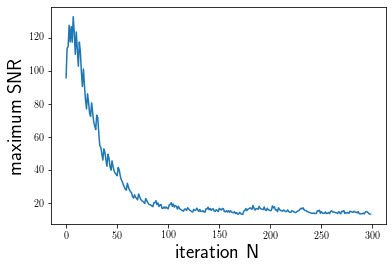

In [33]:
plt.plot(sparse3D.lbd_path[1:300])
plt.xlabel('iteration N',fontsize=20)
plt.ylabel('maximum SNR',fontsize=20)

Text(0, 0.5, 'prob')

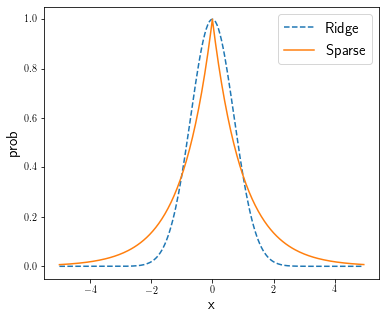

In [53]:
plt.figure(figsize=(6,5))
a=np.arange(-5,5,0.05)
plt.plot(a,np.exp(-a**2.),'--',label='Ridge')
plt.plot(a,np.exp(-np.abs(a)),label='Sparse')
plt.legend(fontsize=15)
plt.xlabel('x',fontsize=15)
plt.ylabel('prob',fontsize=15)

Text(0, 0.5, '$x_2$')

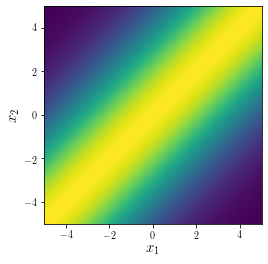

In [69]:
A,B=np.meshgrid(a,a)
C=np.exp(-(A-B)**2./20)
plt.imshow(C,origin='lower',extent=[-5,5,-5,5],interpolation='None')
plt.xlabel(r'$x_1$',fontsize=15)
plt.ylabel(r'$x_2$',fontsize=15)

12.376184466611896
0.6100000000000001 0.6600000000000001
6.58179081757885e+17
7.180608373455897
1156.9095776334646


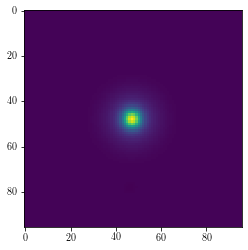

In [28]:
ishow=12
plt.imshow(sparse3D.deltaR[ishow])
print(np.abs(sparse3D.deltaR[ishow]).max())
zav=sparse3D.zlBin[ishow]
zmin=zav-sparse3D.zlscale/2.
zmax=zav+sparse3D.zlscale/2.
print(zmin,zmax)
pix_mpc=halo.cosmo.Da(0.,0.51)*1./60./180.*np.pi
print(halo.Sigma_M_bin(0.50,0.55)*np.sum(sparse3D.deltaR[ishow][24:72,24:72])*pix_mpc**2.)
print(np.average(sparse3D.deltaR[ishow][44:52,44:52]))
print(np.sum(sparse3D.deltaR[ishow]))

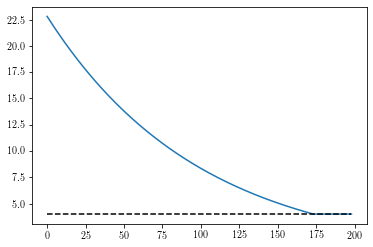

In [48]:
kkkplot(sparse3D.lbd_path[1:200])
plt.plot(4.*np.ones(len(sparse3D.lbd_path))[1:200],'black',ls='--')